In [1]:
import scgen
from scgen import util
import scanpy as sc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/harshita/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harshita/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harshita/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/harshita/.local/lib/python3.6/site-packages/tensorflo

In [4]:
data = sc.read("kang_count.h5ad")

In [5]:
sc.pp.normalize_per_cell(data)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data, n_top_genes=2000)
data = data[:, data.var['highly_variable']]
data

View of AnnData object with n_obs × n_vars = 13576 × 2000 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [13]:
#data.write("kang_count_normalized.h5ad")
data = sc.read("kang_count_normalized.h5ad")
data

AnnData object with n_obs × n_vars = 13576 × 2000 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [14]:
data_train,data_test = train_test_split(data, test_size=0.2)
data_train,data_validate = train_test_split(data_train, test_size=0.2)
data_train

View of AnnData object with n_obs × n_vars = 8688 × 2000 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [18]:
def train_data_keras(z_dim,al=1):
    print(al)
    scg_model = scgen.VAEArithKeras(x_dimension= data_train.shape[1],z_dimension=z_dim, 
                              model_path="./models/keras/",alpha=al)
    scg_model.train(data_train, validation_data=data_validate)
    return scg_model

In [25]:
train_data_keras(5,3000)

3000
Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 5)                 2254410   
_________________________________________________________________
decoder (Model)              (None, 2000)              2252400   
Total params: 4,506,810
Trainable params: 4,500,410
Non-trainable params: 6,400
_________________________________________________________________
Train on 8688 samples, validate on 2172 samples
Epoch 1/25
8688/8688 [==============================] - 38s 4ms/step - loss: 3628.2558 - kl_loss: 1.1744 - recon_loss: 105.0440 - val_loss: 312.5604 - val_kl_loss: 0.0874 - val_recon_loss: 50.4414
Epoch 2/25
8688/8688 [==============================] - 28s 3ms/step - loss: 1053.5800 - kl_loss: 0.3303 - recon_loss: 62.6670 - 

In [12]:
rand_samp = data_test[data_test.obs["condition"]=="control"]
rand_samp_CD4T = rand_samp[rand_samp.obs["cell_type"]=="CD4 T"]
cd4t_sample = rand_samp_CD4T.chunk_X(select=2, replace=False)
cd4t_sample

ArrayView([[0.        , 0.        , 0.67085004, ..., 0.        ,
            0.        , 0.        ],
           [0.        , 0.        , 0.        , ..., 0.        ,
            0.        , 0.        ]], dtype=float32)

In [10]:
#rand_samp = data_test[data_test.obs["condition"]=="control"]
#rand_samp_CD14mono = rand_samp[rand_samp.obs["cell_type"]=="CD14 Mono"]
#cd14mono_sample = rand_samp_CD4T.chunk_X(select=2, replace=False)
cd14mono_sample1 = cd14mono_sample.X[0]
cd14mono_sample2 = cd14mono_sample.X[1]
cd14mono_sample2 = np.reshape(cd14mono_sample2,(1,2000))
cd14mono_sample1 = np.reshape(cd14mono_sample1,(1,2000))
cd14mono_sample2

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
cd4t_sample = sc.read("cd4t_sample.h5ad")
cd4t_sample.X

array([[0.        , 0.        , 0.67085004, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [22]:
cd4t_sample1 = cd4t_sample.X[0]
cd4t_sample2 = cd4t_sample.X[1]
cd4t_sample2 = np.reshape(cd4t_sample2,(1,2000))
cd4t_sample1 = np.reshape(cd4t_sample1,(1,2000))

In [11]:

def analyze_model(path,z_dim,al,cell,cell_name):
    scg_model = scgen.VAEArithKeras(x_dimension= data_train.shape[1],z_dimension=z_dim, 
                               model_path=path,alpha=al)
    scg_model.restore_model()
    cell_in_latentspace = scg_model.to_latent(cell)
    variable_names = data_train.var_names
    #print(variable_names)
    #variable_names = variable_names.append(pd.Index(["sort_key"]))
    increment_range = np.arange(-3,3,0.01)
    for i in range(z_dim):
        result_array = np.empty((0, 2000))
        for inc in increment_range:
            cell_latent = cell_in_latentspace
            cell_latent[:,i] = inc
            cell_recon = scg_model.reconstruct(cell_latent)
            #print(cell_recon)
            #cell_recon = np.append(cell_recon,inc)
            #cell_recon = np.reshape(cell_recon,(1,2000))
            #print(cell_recon)
            result_array = np.append(result_array,cell_recon,axis=0)
        result_adata = sc.AnnData(result_array, obs={"time_key":range(len(result_array))}, var={"var_names":variable_names})   
        result_adata.write(path+cell_name+"_recon_dim_"+str(i)+".h5ad")
        
        

In [ ]:
analyze_model(path = "./models/keras/test5_alpha3000/",z_dim=5,al=3000,cell=cd4t_sample1,cell_name="cd4t_sample1")
analyze_model(path = "./models/keras/test5_alpha3000/",z_dim=5,al=3000,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test5_alpha3000/",z_dim=5,al=3000,cell=cd14mono_sample1,cell_name="cd14mono_sample1")


Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 5)                 2254410   
_________________________________________________________________
decoder (Model)              (None, 2000)              2252400   
Total params: 4,506,810
Trainable params: 4,500,410
Non-trainable params: 6,400
_________________________________________________________________
Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 5)                 2254410   
____________________________________

In [24]:
analyze_model(path = "./models/keras/test5/",z_dim=5,al=1,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test5_alpha10/",z_dim=5,al=10,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test5_alpha20/",z_dim=5,al=20,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test5_alpha100/",z_dim=5,al=100,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test5_alpha1000/",z_dim=5,al=1000,cell=cd4t_sample2,cell_name="cd4t_sample2")

analyze_model(path = "./models/keras/test10/",z_dim=10,al=1,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test10_alpha10/",z_dim=10,al=10,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test10_alpha20/",z_dim=10,al=20,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test10_alpha100/",z_dim=10,al=100,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test10_alpha1000/",z_dim=10,al=1000,cell=cd4t_sample2,cell_name="cd4t_sample2")

analyze_model(path = "./models/keras/test15/",z_dim=15,al=1,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test15_alpha10/",z_dim=15,al=10,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test15_alpha20/",z_dim=15,al=20,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test15_alpha100/",z_dim=15,al=100,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test15_alpha1000/",z_dim=15,al=1000,cell=cd4t_sample2,cell_name="cd4t_sample2")

analyze_model(path = "./models/keras/test20/",z_dim=20,al=1,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test20_alpha10/",z_dim=20,al=10,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test20_alpha20/",z_dim=20,al=20,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test20_alpha100/",z_dim=20,al=100,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test20_alpha1000/",z_dim=20,al=1000,cell=cd4t_sample2,cell_name="cd4t_sample2")

analyze_model(path = "./models/keras/test25/",z_dim=25,al=1,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test25_alpha10/",z_dim=25,al=10,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test25_alpha20/",z_dim=25,al=20,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test25_alpha100/",z_dim=25,al=100,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test25_alpha1000/",z_dim=25,al=1000,cell=cd4t_sample2,cell_name="cd4t_sample2")

analyze_model(path = "./models/keras/test30/",z_dim=30,al=1,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test30_alpha10/",z_dim=30,al=10,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test30_alpha20/",z_dim=30,al=20,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test30_alpha100/",z_dim=30,al=100,cell=cd4t_sample2,cell_name="cd4t_sample2")
analyze_model(path = "./models/keras/test30_alpha1000/",z_dim=30,al=1000,cell=cd4t_sample2,cell_name="cd4t_sample2")


Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 5)                 2254410   
_________________________________________________________________
decoder (Model)              (None, 2000)              2252400   
Total params: 4,506,810
Trainable params: 4,500,410
Non-trainable params: 6,400
_________________________________________________________________
Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 5)                 2254410   
____________________________________

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 15)                2270430   
_________________________________________________________________
decoder (Model)              (None, 2000)              2260400   
Total params: 4,530,830
Trainable params: 4,524,430
Non-trainable params: 6,400
_________________________________________________________________
Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 15)                2270430   
____________________________________

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 25)                2286450   
_________________________________________________________________
decoder (Model)              (None, 2000)              2268400   
Total params: 4,554,850
Trainable params: 4,548,450
Non-trainable params: 6,400
_________________________________________________________________
Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 25)                2286450   
____________________________________

In [15]:
'''
analyze_model(path = "./models/keras/test5/",z_dim=5,al=1,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test5_alpha10/",z_dim=5,al=10,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test5_alpha20/",z_dim=5,al=20,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test5_alpha100/",z_dim=5,al=100,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test5_alpha1000/",z_dim=5,al=1000,cell=cd14mono_sample1,cell_name="cd14mono_sample1")

analyze_model(path = "./models/keras/test10/",z_dim=10,al=1,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test10_alpha10/",z_dim=10,al=10,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test10_alpha20/",z_dim=10,al=20,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test10_alpha100/",z_dim=10,al=100,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test10_alpha1000/",z_dim=10,al=1000,cell=cd14mono_sample1,cell_name="cd14mono_sample1")

analyze_model(path = "./models/keras/test15/",z_dim=15,al=1,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test15_alpha10/",z_dim=15,al=10,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test15_alpha20/",z_dim=15,al=20,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test15_alpha100/",z_dim=15,al=100,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test15_alpha1000/",z_dim=15,al=1000,cell=cd14mono_sample1,cell_name="cd14mono_sample1")

analyze_model(path = "./models/keras/test20/",z_dim=20,al=1,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
'''
analyze_model(path = "./models/keras/test20_alpha10/",z_dim=20,al=10,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test20_alpha20/",z_dim=20,al=20,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test20_alpha100/",z_dim=20,al=100,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test20_alpha1000/",z_dim=20,al=1000,cell=cd14mono_sample1,cell_name="cd14mono_sample1")

analyze_model(path = "./models/keras/test25/",z_dim=25,al=1,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test25_alpha10/",z_dim=25,al=10,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test25_alpha20/",z_dim=25,al=20,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test25_alpha100/",z_dim=25,al=100,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test25_alpha1000/",z_dim=25,al=1000,cell=cd14mono_sample1,cell_name="cd14mono_sample1")

analyze_model(path = "./models/keras/test30/",z_dim=30,al=1,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test30_alpha10/",z_dim=30,al=10,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test30_alpha20/",z_dim=30,al=20,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test30_alpha100/",z_dim=30,al=100,cell=cd14mono_sample1,cell_name="cd14mono_sample1")
analyze_model(path = "./models/keras/test30_alpha1000/",z_dim=30,al=1000,cell=cd14mono_sample1,cell_name="cd14mono_sample1")


Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 20)                2278440   
_________________________________________________________________
decoder (Model)              (None, 2000)              2264400   
Total params: 4,542,840
Trainable params: 4,536,440
Non-trainable params: 6,400
_________________________________________________________________

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 20)                2278440   
___________________________________

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 30)                2294460   
_________________________________________________________________
decoder (Model)              (None, 2000)              2272400   
Total params: 4,566,860
Trainable params: 4,560,460
Non-trainable params: 6,400
_________________________________________________________________
Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
encoder (Model)              (None, 30)                2294460   
____________________________________

In [51]:
c = scg_10_10.to_latent(cd4t_sample1)
d = np.append(c,4)
d = np.reshape(d,(1,11))
d

array([[ 0.25931102,  0.0450611 ,  0.08912423,  0.09145215,  0.81327939,
         0.91127604,  0.49951315, -0.53062832, -0.71647149,  0.42738542,
         4.        ]])

In [17]:
dim0 = sc.read("./models/keras/test5/recon_dim_0.h5ad")
dim0.X

array([[ 9.0000476e-14,  3.7306590e-14, -3.9545589e-24, ...,
         4.5371644e-17, -9.5884212e-18,  2.7104288e-15],
       [-1.3309869e-13,  3.9211438e-12, -8.5893695e-13, ...,
         1.0329019e-17, -2.3395812e-12,  6.9701375e-17],
       [-1.8659458e-17, -3.5752302e-16, -6.7092139e-07, ...,
        -2.9920926e-15, -7.0293450e-12, -4.1135462e-16],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [22]:
all_LATENT = sc.AnnData(scg_10_10.to_latent(data_train.X))

NameError: name 'scg_10_10' is not defined

In [23]:
all_LATENT.obs = data_train.obs

NameError: name 'all_LATENT' is not defined

In [24]:
scg_10_10 = scgen.VAEArithKeras(x_dimension= data_train.shape[1],z_dimension=10, 
                               model_path="./models/keras/test10_alpha10/",alpha=10)
scg_10_10.restore_model()sc.pp.neighbors(all_LATENT)
sc.tl.umap(all_LATENT)

NameError: name 'all_LATENT' is not defined

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


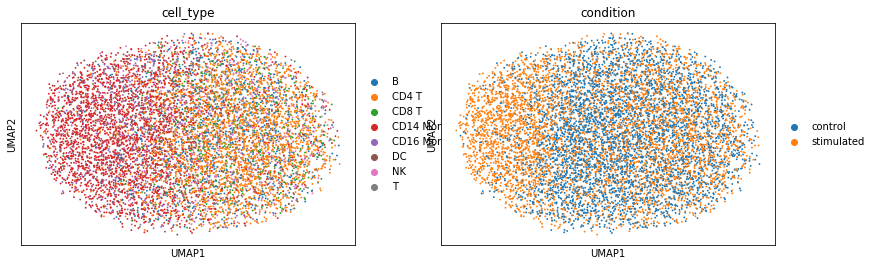

In [19]:
sc.pl.umap(all_LATENT, color=["cell_type", "condition"])

In [10]:
cd4t_sample
cd4t_sample_latent = scg_10_10.to_latent(cd4t_sample)
cd4t_sample_latent

array([[ 1.3212404 , -0.96376324,  0.97434413, ...,  0.546119  ,
         1.3369936 ,  0.62678623],
       [ 0.47721806,  0.48896578,  0.3710116 , ...,  1.4888448 ,
         0.5431168 ,  1.8498526 ],
       [-0.34163514,  0.75196916,  0.8296501 , ..., -1.0946128 ,
        -0.6779203 ,  0.24493414],
       ...,
       [ 0.48494872,  0.68506473,  0.06830657, ...,  0.34954852,
         0.76677454,  0.07904392],
       [ 1.1342162 , -0.39783856, -1.8278755 , ..., -0.7120322 ,
         2.4283812 ,  0.6935736 ],
       [-1.0855496 ,  0.01628748, -1.101874  , ...,  0.1130788 ,
        -0.39264965,  1.0399802 ]], dtype=float32)

In [22]:
min(all_LATENT.X[:,0])

-3.578028

In [23]:
max(all_LATENT.X[:,0])

3.8267503

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


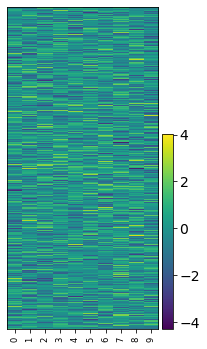

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0, 3.0, 0, 0.2])

In [28]:
sc.pl.heatmap(all_LATENT,var_names=all_LATENT.var_names)


In [ ]:

#cd4t sc.tl.pca()
monitor genes
sc.pl.


In [142]:
rand_samp = data_test[data_test.obs["condition"]=="control"]
rand_samp_CD4T = rand_samp[rand_samp.obs["cell_type"]=="CD4 T"]
cd4t_sample = rand_samp_CD4T.chunk_X(select=2, replace=False)

rand_samp = data_test[data_test.obs["condition"]=="control"]
rand_samp_CD14mono = rand_samp[rand_samp.obs["cell_type"]=="CD14 Mono"]
cd14mono_sample = rand_samp_CD4T.chunk_X(select=2, replace=False)

print(cd4t_sample,cd14mono_sample)

[[0.        0.        0.6664022 ... 0.        0.        0.       ]
 [0.        0.        0.7575584 ... 0.        0.        0.       ]] [[0.         0.         0.9773475  ... 0.         0.         0.        ]
 [0.         0.         0.82113314 ... 0.         0.         0.        ]]


In [154]:
cd4t_sample_latent = scg_10_10.to_latent(cd4t_sample)
cd14mono_sample_latent = scg_10_10.to_latent(cd14mono_sample)

In [136]:
cd4t_sample_latent
#cd14mono_sample_latent
cd4t_1 = cd4t_sample_latent[0]
#scg_10_10.reconstruct(cd4t_1)
cd4t_sample_latent
cd4t_1 = np.reshape(cd4t_1,(1,10))
cd4t_1[0][0]

1.6436219

In [ ]:
cd4t_sample_latent = scg_10_10.to_latent(cd4t_sample)
#cd14mono_sample_latent = scg_10_10.to_latent(cd14mono_sample)

def recon_cell(sample,dim):
    
    sample = np.reshape(sample,(1,10))
    x_dim = int((3 - sample[0][dim])/0.01)
    result_array = np.empty((x_dim, 2000))
    
    while sample[0][dim] <= 3:
        sample[0][dim] = sample[0][dim]+0.01
        np.append(result_array,scg_10_10.reconstruct(sample),axis=0)
    return result_array


cells = cd4t_sample_latent
df = pd.DataFrame(columns=data_train.var_names)
df["cell"] = -4

for l in range(len(cells)):
    monitor_dim = 0
    cd4t_result = recon_cell(cells[l],monitor_dim)
    df2 = pd.DataFrame(data=cd4t_result,columns=data_train.var_names)
    df2["cell"] = cells[l][monitor_dim]
    df = pd.concat([df,df2])

#cd4t_result = np.asarray(cd4t_result)

result_adata = sc.AnnData(cd4t_result, obs={"condition":["reconstructed"]*len(cd4t_result)}, var={"var_names":data_train.var_names})
#result_df = result_adata.to_df()

df